In [ ]:
"""Data Exploration"""

'Data Exploration'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import statsmodels.formula.api as smf

In [ ]:
file_path = "/content/drive/MyDrive/Applied research project/Data_X/Final-V14-news_updated.xlsx"
df = pd.read_excel(file_path)

In [ ]:
df = df[df['Total_News'] != 0]
print("New shape after removing rows with Total_News = 0:", df.shape)

New shape after removing rows with Total_News = 0: (2801, 207)


In [ ]:
# Drop columns
df.drop(columns=["Location_Group", "Population_Group", "Entrepreneurial Index Score", "Tax_Ratio"], inplace=True)
# Removed the empty string "" from the list of columns to drop
df = df[df['Total_News'] != 0]
print("New shape after removing rows with Total_News = 0:", df.shape)

New shape after removing rows with Total_News = 0: (2801, 203)


In [ ]:
### Data Profiling and Structure Examination
df.info()
print("Data dimension", df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 2801 entries, 1 to 5145
Columns: 203 entries, COMPANY_ID to is_top_university
dtypes: datetime64[ns](1), float64(12), int64(187), object(3)
memory usage: 4.4+ MB
Data dimension (2801, 203)


In [ ]:
# Get the column names
dtype_columns = {}
for col in df.columns:
    dtype = str(df[col].dtype)
    if dtype not in dtype_columns:
        dtype_columns[dtype] = []
    dtype_columns[dtype].append(col)

for dtype, cols in dtype_columns.items():
    print(f"\n=== Data type: {dtype} ===")
    print(f"columns number: {len(cols)}")
    print("Column name:")
    print(', '.join(cols))


=== Data type: object ===
columns number: 3
Column name:
COMPANY_ID, ADJ_EXITED_ON, ADJ_CLOSED_ON

=== Data type: int64 ===
columns number: 187
Column name:
dummy_software, dummy_information technology, dummy_health care, dummy_e commerce, dummy_mobile, dummy_internet, dummy_saas, dummy_apps, dummy_analytics, dummy_enterprise software, dummy_financial services, dummy_artificial intelligence, dummy_fintech, dummy_biotechnology, dummy_social media, dummy_big data, dummy_medical, dummy_education, dummy_machine learning, dummy_mobile apps, dummy_advertising, dummy_marketplace, dummy_finance, dummy_internet of things, dummy_retail, dummy_manufacturing, dummy_travel, dummy_food and beverage, dummy_fashion, dummy_medical device, dummy_marketing, dummy_video, dummy_b2b, dummy_real estate, dummy_information services, dummy_hardware, dummy_security, dummy_computer, dummy_payments, dummy_cloud computing, dummy_automotive, dummy_wellness, dummy_digital media, dummy_transportation, dummy_pharmaceu

In [ ]:
# Identify dummy columns based on data values
# A column is considered dummy if all non-missing values are in {0, 1}.
dummy_cols = []
for col in df.columns:
    # Get unique non-null values
    unique_vals = df[col].dropna().unique()
    # Check if the unique values are a subset of {0, 1}
    if set(unique_vals).issubset({0, 1}):
        dummy_cols.append(col)
print("Identified dummy columns:", dummy_cols)
# Identify all numeric columns (including those that might be dummy)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Exclude dummy columns from numeric_cols to get truly numeric (non-binary) columns
non_dummy_numeric = [col for col in numeric_cols if col not in dummy_cols]
print("Truly numeric (non-binary) columns:", non_dummy_numeric)
# Display descriptive statistics for non-dummy numeric columns
print("Descriptive statistics for non-dummy numeric columns:")
print(df[non_dummy_numeric].describe())
# For dummy variables, check frequency counts (0's and 1's)
print("\nFrequency counts for dummy variables:")
for col in dummy_cols:
    print(f"\nValue counts for '{col}':")
    print(df[col].value_counts())

Identified dummy columns: ['dummy_software', 'dummy_information technology', 'dummy_health care', 'dummy_e commerce', 'dummy_mobile', 'dummy_internet', 'dummy_saas', 'dummy_apps', 'dummy_analytics', 'dummy_enterprise software', 'dummy_financial services', 'dummy_artificial intelligence', 'dummy_fintech', 'dummy_biotechnology', 'dummy_social media', 'dummy_big data', 'dummy_medical', 'dummy_education', 'dummy_machine learning', 'dummy_mobile apps', 'dummy_advertising', 'dummy_marketplace', 'dummy_finance', 'dummy_internet of things', 'dummy_retail', 'dummy_manufacturing', 'dummy_travel', 'dummy_food and beverage', 'dummy_fashion', 'dummy_medical device', 'dummy_marketing', 'dummy_video', 'dummy_b2b', 'dummy_real estate', 'dummy_information services', 'dummy_hardware', 'dummy_security', 'dummy_computer', 'dummy_payments', 'dummy_cloud computing', 'dummy_automotive', 'dummy_wellness', 'dummy_digital media', 'dummy_transportation', 'dummy_pharmaceutical', 'dummy_consumer electronics', 'dum

In [ ]:
###Feature engineering

# Convert 'ADJ_FOUNDED_ON' to datetime and extract the founding year
df['founded_year'] = pd.to_datetime(df['ADJ_FOUNDED_ON'], errors='coerce').dt.year

def extract_exited_year(value):
    # If the startup still not exited
    if isinstance(value, str) and value.strip().lower() == "not exited yet":
        # Use 0
        return 0
    else:
        # Try to convert the value to a datetime and extract the year
        try:
            return pd.to_datetime(value, errors='coerce').year
        except Exception as e:
            return 0

# Apply the function to create a new 'closed_year' column
df['exit_year'] = df['ADJ_EXITED_ON'].apply(extract_exited_year)

# Convert datetime columns to numerical before setting X and y
datetime_cols = df.select_dtypes(include=['datetime64']).columns
for col in datetime_cols:
    df[col] = df[col].apply(lambda x: x.toordinal() if pd.notnull(x) else x)

# Apply log transformation to reduce skew on money columns.
df['Average_Money_Raised_log'] = np.log(df['Average_Money_Raised'] + 1)
df['Total_Money_Raised_log'] = np.log(df['Toatl_Money_Raised'] + 1)
df['Money_Raised_Ratio'] = df['Average_Money_Raised_log'] / (df['Total_Money_Raised_log'] + 1e-8)

In [ ]:
# Add new date columns
new_date_columns = ['founded_year', 'exit_year'] + datetime_cols.tolist()

# Add into non-dummy group
non_dummy_numeric = list(set(non_dummy_numeric + new_date_columns))

In [ ]:
# New feature calculate the currunt year-founding year and divide the total news to get average news per year
# Get the current year furst
current_year = pd.Timestamp.now().year
# Calculate the 'Yearly_Exposure' column
df['Yearly_Exposure'] = df['Total_News'] / (current_year - df['founded_year'] + 1)

   Class  Count  Proportion
0      1   1717       0.613
1      0   1084       0.387


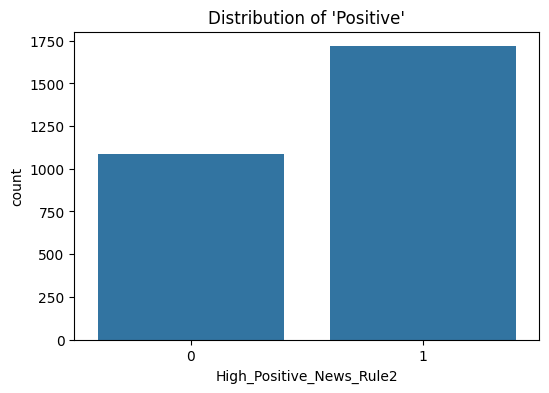

In [ ]:
df['High_Positive_News_Rule2'] = (
    (df['SUM_Sentiment_Category_Positive'] + df['SUM_Sentiment_Category_Very Positive']) >
    (df['SUM_Sentiment_Category_Negative'] + df['SUM_Sentiment_Category_Very Negative'])
).astype(int)

# Class distribution for the new target
new_dist = df['High_Positive_News_Rule2'].value_counts().rename_axis('Class').reset_index(name='Count')
new_dist['Proportion'] = (new_dist['Count'] / len(df)).round(3)
print(new_dist)

# check the distribution of target variable
if "High_Positive_News_Rule2" in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x="High_Positive_News_Rule2", data=df)
    plt.title("Distribution of 'Positive'")
    plt.show()

In [ ]:
## Check for missing values in the entire DataFrame
total_nans = df.isnull().sum().sum()
print("Total NaNs in DataFrame:", total_nans)

# List all columns that contain NaN values
nan_columns = df.columns[df.isnull().any()].tolist()
print("Columns with NaN values:", nan_columns)

# Check empty strings, replace them with np.nan and check again
df_cleaned = df.replace(r'^\s*$', np.nan, regex=True)
nan_columns_after_replace = df_cleaned.columns[df_cleaned.isnull().any()].tolist()
print("Columns with NaN values after replacing empty strings:", nan_columns_after_replace)

# Check for infinite values in numeric columns
numeric_cols = df.select_dtypes(include=[np.number])
inf_counts = (numeric_cols == np.inf).sum() + (numeric_cols == -np.inf).sum()
inf_columns = inf_counts[inf_counts > 0].index.tolist()
print("Columns with infinite values:", inf_columns)

Total NaNs in DataFrame: 25460
Columns with NaN values: ['Acquihire', 'Acquisition', 'Leveraged Buyout', 'Merger', 'No Acquisition Type', 'Acquihire_dummy', 'Acquisition_dummy', 'Leveraged Buyout_dummy', 'Merger_dummy', 'NoAcquisitionType_dummy']
Columns with NaN values after replacing empty strings: ['Acquihire', 'Acquisition', 'Leveraged Buyout', 'Merger', 'No Acquisition Type', 'Acquihire_dummy', 'Acquisition_dummy', 'Leveraged Buyout_dummy', 'Merger_dummy', 'NoAcquisitionType_dummy']
Columns with infinite values: []


In [ ]:
# Handle NaN in investment
df.fillna(0, inplace=True)

In [ ]:
df.drop(columns=['Sentiment_Category_Negative',
             'Sentiment_Category_Neutral','Sentiment_Category_Positive',
             'Sentiment_Category_Very Negative','Sentiment_Category_Very Positive','SUM_Sentiment_Category_Negative',
             'SUM_Sentiment_Category_Positive','SUM_Sentiment_Category_Very Negative',
             'SUM_Sentiment_Category_Very Positive','Sentiment_Category_Neutral','Average_Money_Raised', 'Toatl_Money_Raised','Total_News',
                 'Average_Money_Raised_log','Total_Money_Raised_log'], inplace=True)

In [ ]:
from scipy.stats import pointbiserialr
#Point-Biserial for numeric vs. binary target
pb_results = []
for col in non_dummy_numeric:
    if col in df.columns:
        valid_index = df[col].dropna().index
        x = df[col].loc[valid_index]
        y_vals = df['High_Positive_News_Rule2'].loc[valid_index]
        r, pval = pointbiserialr(x, y_vals)
        pb_results.append((col, r, pval))

df_pb = pd.DataFrame(pb_results, columns=["Feature", "MetricValue", "p_value"])

# Center the title when printing
title_str = "---Point-Biserial Correlation---"
# Here we center it within 80 characters; adjust as needed
print(f"\n{title_str:^80}")

# Print the DataFrame without row indices
print(df_pb.to_string(index=False))


                        ---Point-Biserial Correlation---                        
                                    Feature  MetricValue      p_value
                             Industry_Group     0.019606 2.996135e-01
            FUNDING_TYPE_Convertible Note.1    -0.001120 9.527380e-01
                    FUNDING_TYPE_Series F.1     0.042702 2.382170e-02
                                  exit_year     0.015509 4.119265e-01
                             ADJ_FOUNDED_ON     0.001764 9.256539e-01
         FUNDING_TYPE_Equity Crowdfunding.1    -0.032103 8.937439e-02
                                Acquisition     0.056622 2.719919e-03
                        FUNDING_TYPE_Seed.1     0.047600 1.175151e-02
                    FUNDING_TYPE_Series E.1     0.041775 2.704182e-02
                         Total_Funding Type     0.124303 4.074408e-11
                               founded_year     0.003725 8.437778e-01
               AGGREG_INVESTMENT_STAGE_Seed     0.054872 3.673041e-03
        

In [ ]:
from scipy.stats import chi2_contingency
def cramers_v(x, y):
    # Build a contingency table
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.to_numpy().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    # Avoid division by zero; if one dimension is less than 2, return NaN for both
    if min(r, k) < 2:
        return np.nan, np.nan

    cv = np.sqrt(phi2 / (min(k - 1, r - 1)))
    return cv, p

ordered_cats = ["Industry_Group"]

cv_results = []
for col in ordered_cats:
    if col in df.columns:
        # Filter out missing data for both col and target
        valid_index = df[col].dropna().index
        x = df[col].loc[valid_index]
        y_vals = df['High_Positive_News_Rule2'].loc[valid_index]

        # Compute Cramer's V and p-value
        cv, pval = cramers_v(x, y_vals)
        cv_results.append((col, cv, pval))

df_cv = pd.DataFrame(cv_results, columns=["Feature", "CramersV", "p_value"])
df_cv.sort_values(by="CramersV", ascending=False, inplace=True)

print("---Cramer's V Correlation---")
print(df_cv.to_string(index=False))


---Cramer's V Correlation---
       Feature  CramersV  p_value
Industry_Group  0.087945 0.041463


In [ ]:
#Phi for dummy vs. binary target
def phi_coefficient(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.values.sum()
    phi = np.sqrt(chi2 / n)
    return phi, p

phi_results = []
for col in dummy_cols:
    if col in df.columns:
        valid_index = df[col].dropna().index
        x = df[col].loc[valid_index]
        y_vals = df['High_Positive_News_Rule2'].loc[valid_index]
        if set(x.unique()).issubset({0,1}) and set(y_vals.unique()).issubset({0,1}):
            phi, pval = phi_coefficient(x, y_vals)
            phi_results.append((col, phi, pval))

df_phi = pd.DataFrame(phi_results, columns=["Feature", "MetricValue", "p_value"])

# Print the results
title_str = "--- Phi Correlation ---"
# Center the title within 80 characters
print(f"\n{title_str:^80}")
print(df_phi.to_string(index=False))


                            --- Phi Correlation ---                             
                              Feature  MetricValue      p_value
                       dummy_software     0.046602 1.364790e-02
         dummy_information technology     0.013260 4.828090e-01
                    dummy_health care     0.025571 1.759444e-01
                     dummy_e commerce     0.020865 2.694821e-01
                         dummy_mobile     0.011194 5.535758e-01
                       dummy_internet     0.014338 4.479582e-01
                           dummy_saas     0.015435 4.140016e-01
                           dummy_apps     0.001760 9.258036e-01
                      dummy_analytics     0.031476 9.574328e-02
            dummy_enterprise software     0.015018 4.267157e-01
             dummy_financial services     0.007309 6.988753e-01
        dummy_artificial intelligence     0.016080 3.947448e-01
                        dummy_fintech     0.018975 3.152509e-01
                  dumm

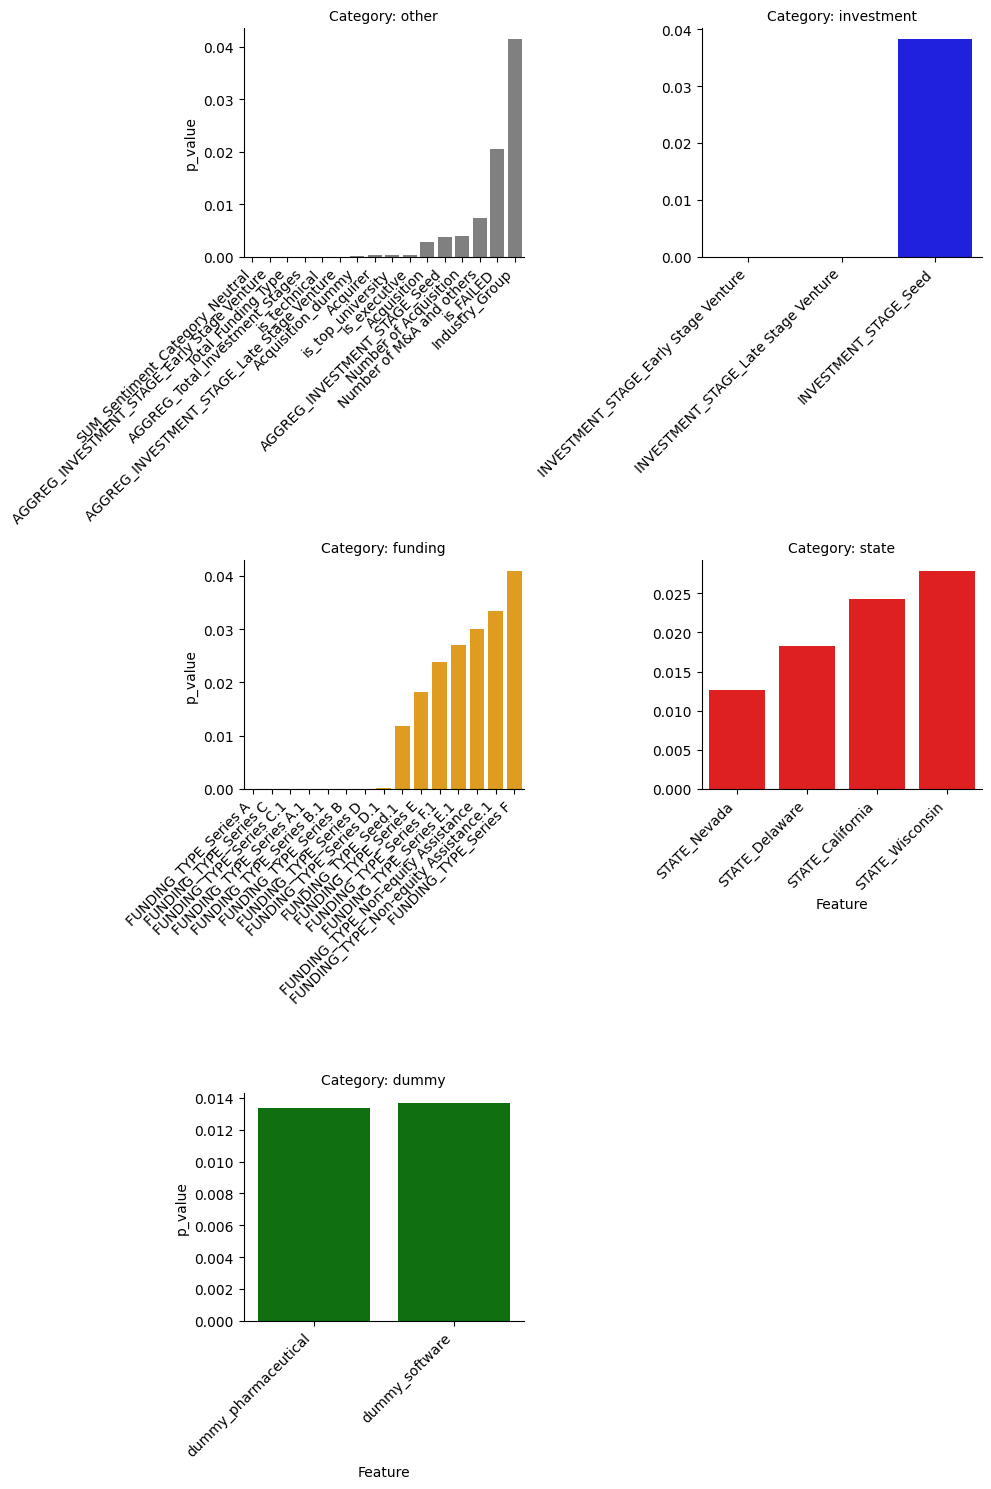

In [ ]:
# Categorize the features and rank them by the p-value
df_all = pd.concat([df_pb, df_phi, df_cv], ignore_index=True)
def get_category(feature_name):
    f_lower = feature_name.lower()
    if f_lower.startswith("investment"):
        return "investment"
    elif f_lower.startswith("funding"):
        return "funding"
    elif f_lower.startswith("dummy"):
        return "dummy"
    elif f_lower.startswith("state"):
        return "state"
    else:
        return "other"

df_all["Category"] = df_all["Feature"].apply(get_category)
top_n = 40
df_all_sorted = df_all.sort_values(by="p_value", ascending=True).head(top_n)
custom_palette = {
    "investment": "blue",
    "funding": "orange",
    "dummy": "green",
    "state": "red",
    "other": "gray"
}

# Create the FacetGrid; each facet corresponds to a category.
g = sns.FacetGrid(df_all_sorted, col="Category", col_wrap=2, height=5, sharex=False, sharey=False)

# Modify the facet_barplot function to use the custom color for the current category
def facet_barplot(data, **kwargs):
    # Sort the data by p_value ascending for better visual order
    data = data.sort_values(by="p_value", ascending=True)
    # All rows in this facet belong to the same category; grab it from the first row
    category = data["Category"].iloc[0]
    color = custom_palette.get(category, "gray")
    # Remove the 'color' argument from kwargs if it exists
    kwargs.pop('color', None)
    sns.barplot(x="Feature", y="p_value", data=data, color=color, **kwargs)
    plt.xticks(rotation=45, ha='right')

g.map_dataframe(facet_barplot)  # No need to pass color=None
g.set_titles(col_template="Category: {col_name}")
g.set_axis_labels("Feature", "p_value")

plt.tight_layout()
plt.show()

In [ ]:
# Define feature matrix X and target y.
X = df.drop(['High_Positive_News_Rule2',
             'ADJ_FOUNDED_ON','ADJ_EXITED_ON', 'ADJ_CLOSED_ON','COMPANY_ID'], axis=1)
# sentiment_cols = [col for col in X.columns if 'Sentiment_Category' in col or 'Total_News' in col]
sentiment_cols = [col for col in X.columns if 'Sentiment_Category' in col]

X = X.drop(sentiment_cols, axis=1)
y = df['High_Positive_News_Rule2']

In [ ]:
import numpy as np
import pprint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from imblearn.over_sampling import SMOTE

# -----------------------------------------------------------------------------------
def get_metrics(y_true, y_pred, y_proba):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred, zero_division=0)
    metrics['recall'] = recall_score(y_true, y_pred, zero_division=0)
    metrics['f1'] = f1_score(y_true, y_pred, zero_division=0)
    if y_proba is not None:
        metrics['auc'] = roc_auc_score(y_true, y_proba)
    else:
        metrics['auc'] = np.nan
    return metrics

# -----------------------------------------------------------------------------------
# Core function: evaluate a model using cross validation with a given balancing strategy.
def evaluate_model(model, X, y, balancing, cv_splits=5, random_state=42):
    """
    balancing: one of 'none', 'smote', or 'class_weight'
    """
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    train_metrics_list = []
    test_metrics_list = []

    for train_index, test_index in skf.split(X, y):
        # Use .iloc if X and y are pandas objects to select rows by integer location.
        try:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        except AttributeError:
            # If X and y are numpy arrays.
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

        sample_weights = None  # For class weighting (if needed)

        # Apply SMOTE on the training data only.
        if balancing == 'smote':
            sm = SMOTE(random_state=random_state)
            X_train, y_train = sm.fit_resample(X_train, y_train)

        # For class_weight balancing:
        if balancing == 'class_weight':
            # For MLPClassifier, sample_weight is not supported.
            if isinstance(model, MLPClassifier):
                sample_weights = None
            else:
                classes = np.unique(y_train)
                weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
                class_weight_dict = dict(zip(classes, weights))
                sample_weights = np.array([class_weight_dict[label] for label in y_train])

        # Fit the model with or without sample weights.
        if sample_weights is not None:
            model.fit(X_train, y_train, sample_weight=sample_weights)
        else:
            model.fit(X_train, y_train)

        # In-sample (training) predictions
        y_train_pred = model.predict(X_train)
        try:
            y_train_proba = model.predict_proba(X_train)[:, 1]
        except Exception:
            try:
                y_train_proba = model.decision_function(X_train)
            except Exception:
                y_train_proba = None
        train_metrics = get_metrics(y_train, y_train_pred, y_train_proba)

        # Out-of-sample (testing) predictions
        y_test_pred = model.predict(X_test)
        try:
            y_test_proba = model.predict_proba(X_test)[:, 1]
        except Exception:
            try:
                y_test_proba = model.decision_function(X_test)
            except Exception:
                y_test_proba = None
        test_metrics = get_metrics(y_test, y_test_pred, y_test_proba)

        train_metrics_list.append(train_metrics)
        test_metrics_list.append(test_metrics)

    # Average the metrics across folds.
    avg_train_metrics = {k: np.mean([m[k] for m in train_metrics_list]) for k in train_metrics_list[0]}
    avg_test_metrics = {k: np.mean([m[k] for m in test_metrics_list]) for k in test_metrics_list[0]}
    return avg_train_metrics, avg_test_metrics

# -----------------------------------------------------------------------------------
# Main function: define all models and run evaluations for each balancing strategy.
def run_all_models(X, y):
    results = {}

    # Define model instances.
    models = {
        'RandomForest': {
            'base': RandomForestClassifier(random_state=42),
            'class_weight': RandomForestClassifier(class_weight='balanced', random_state=42)
        },
        'LogisticRegression': {
            'base': LogisticRegression(max_iter=2000, random_state=42),
            'class_weight': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
        },
        'SVM': {
            'base': SVC(probability=True, random_state=42),
            'class_weight': SVC(probability=True, class_weight='balanced', random_state=42)
        },
        'XGBoost': {
            'base': xgb.XGBClassifier(eval_metric='logloss', random_state=42),
            'class_weight': None  # Created dynamically below.
        },
        'NeuralNetwork': {
            'base': MLPClassifier(max_iter=500, random_state=42)
        }
    }

    balancing_methods = ['none', 'smote', 'class_weight']

    for model_name, model_dict in models.items():
        results[model_name] = {}
        for balancing in balancing_methods:
            if model_name == 'XGBoost' and balancing == 'class_weight':
                pos = np.sum(y == 1)
                neg = np.sum(y == 0)
                scale_pos_weight = neg / pos if pos > 0 else 1
                model_instance = xgb.XGBClassifier(eval_metric='logloss',
                                                   random_state=42,
                                                   scale_pos_weight=scale_pos_weight)
            elif balancing == 'class_weight' and model_name in ['RandomForest', 'LogisticRegression', 'SVM']:
                model_instance = model_dict['class_weight']
            else:
                model_instance = model_dict['base']

            model_instance = clone(model_instance)
            train_metrics, test_metrics = evaluate_model(model_instance, X, y, balancing, cv_splits=5)
            results[model_name][balancing] = {
                'in_sample': train_metrics,
                'out_sample': test_metrics
            }

    return results

# ----------------------------------------------------------------------------------
# X, y = make_classification(n_samples=1000, n_features=20, n_informative=10,
#                            n_redundant=5, n_clusters_per_class=2, weights=[0.9, 0.1],
#                            random_state=42)

results = run_all_models(X, y)
pprint.pprint(results)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

{'LogisticRegression': {'class_weight': {'in_sample': {'accuracy': np.float64(0.5941615270606235),
                                                       'auc': np.float64(0.7460779156018752),
                                                       'f1': np.float64(0.5454237913558965),
                                                       'precision': np.float64(0.8696101696200159),
                                                       'recall': np.float64(0.3974923959794371)},
                                         'out_sample': {'accuracy': np.float64(0.5644365928189459),
                                                        'auc': np.float64(0.6806011290194129),
                                                        'f1': np.float64(0.5125762941290894),
                                                        'precision': np.float64(0.8163969788111572),
                                                        'recall': np.float64(0.3739168757203878)}},
                        'n

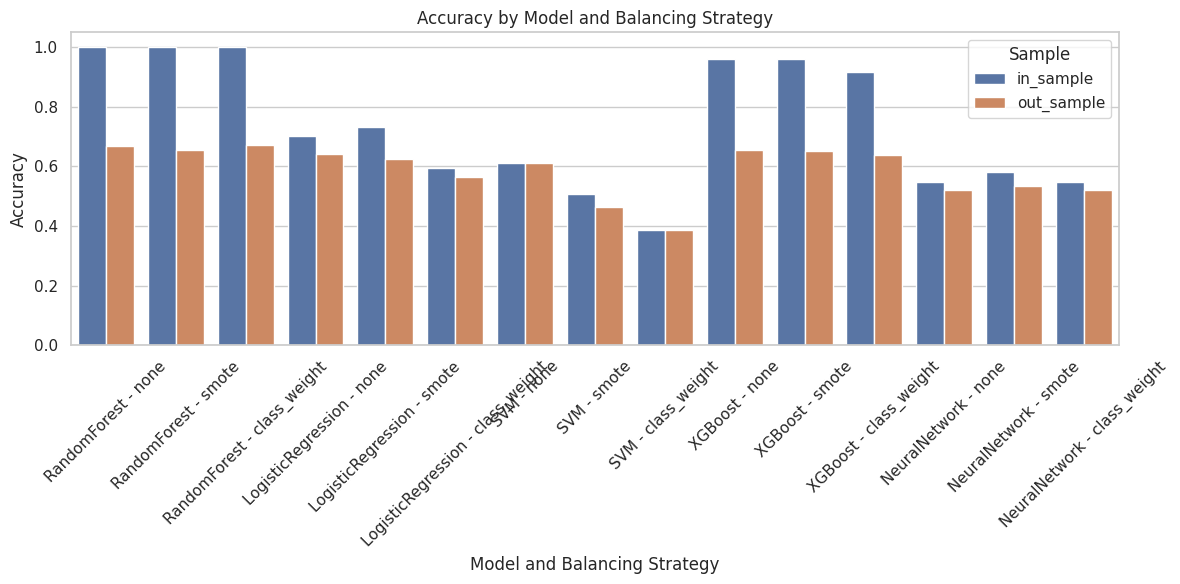

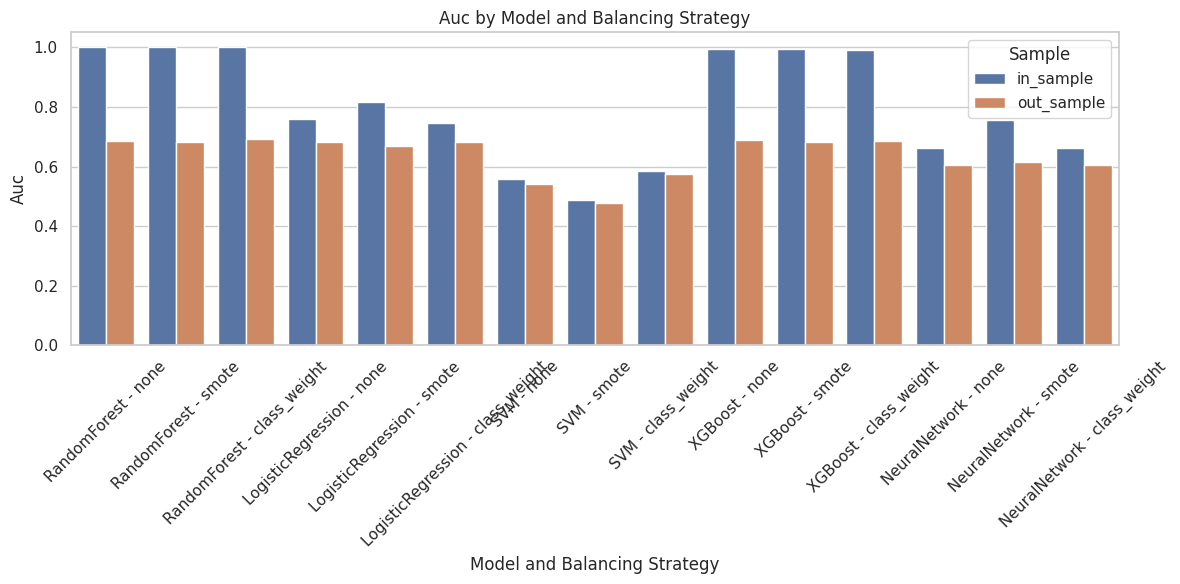

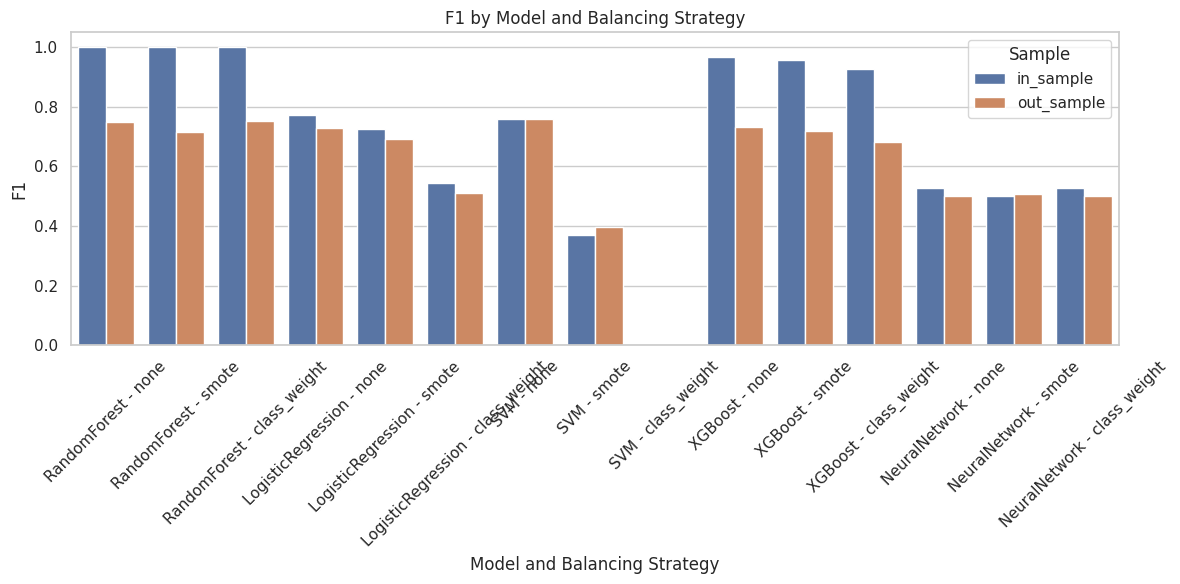

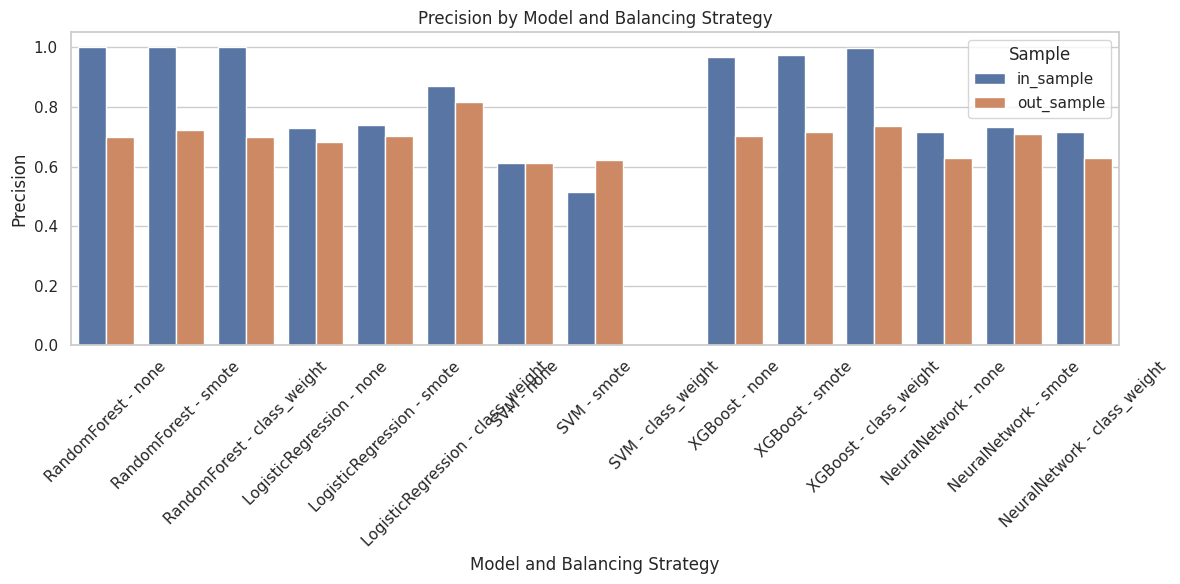

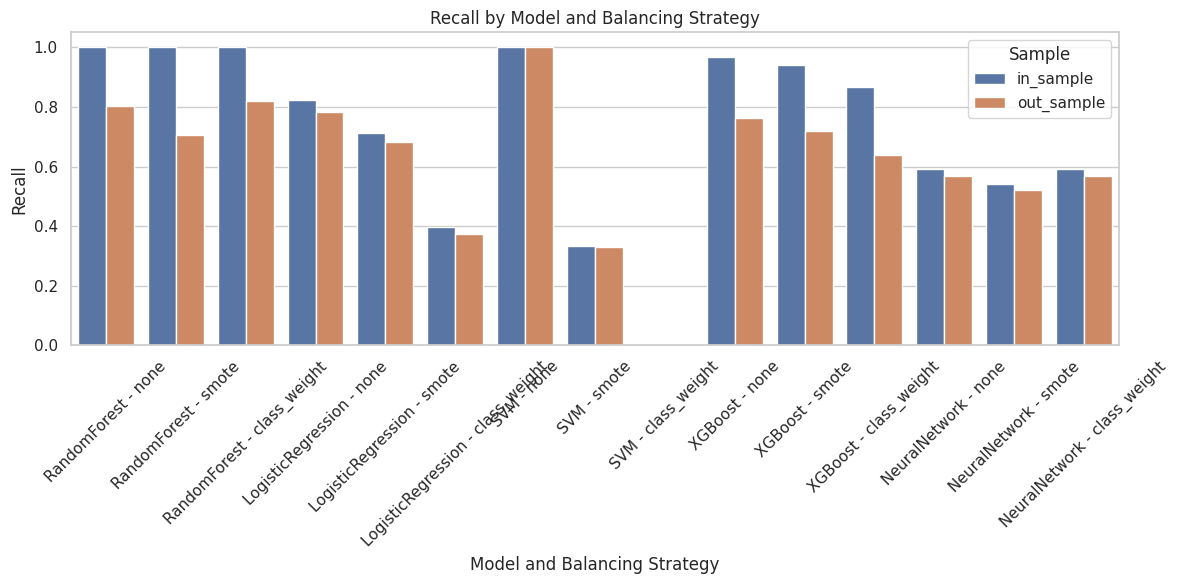

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Transform the nested dictionary into a flat DataFrame.
records = []
for model, model_data in results.items():
    for strategy, strat_data in model_data.items():
        for sample in ['in_sample', 'out_sample']:
            record = {
                'Model': model,
                'Balancing': strategy,
                'Sample': sample
            }
            # Convert each metric to float and add to the record.
            record.update({metric: float(val) for metric, val in strat_data[sample].items()})
            records.append(record)

df = pd.DataFrame(records)

# Create a new column to combine Model and Balancing for easier plotting.
df['Model_Balancing'] = df['Model'] + ' - ' + df['Balancing']

# List of metrics to visualize.
metrics = ['accuracy', 'auc', 'f1', 'precision', 'recall']

# Set a Seaborn style.
sns.set(style="whitegrid")

# Loop over each metric and create a bar plot.
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='Model_Balancing', y=metric, hue='Sample')
    plt.title(f"{metric.capitalize()} by Model and Balancing Strategy")
    plt.xlabel("Model and Balancing Strategy")
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
